In [1]:
#
# Initialization
#
import os
import sys

import ipynbname
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same
MODULE_PATH = ipynbname.path().parent.parent
sys.path.append(str(MODULE_PATH))

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# This should always be `./src`
print(f"Current working directory [{os.getcwd()}]")

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Current working directory [/Users/jbeckman/projects/capia/src]


In [2]:
#
# Setup utils
#

import subprocess

from utils.logger_util import LoggerUtil
from utils.utils import Utils
from utils import config

LOGGER = LoggerUtil(config.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

# AWS instance specs can be found here https://aws.amazon.com/sagemaker/pricing/
AWS_INSTANCE = 'ml.m5.large' # 2 vCPU, 0 GPU, 8 GB memory, $0.134/hour
AWS_INSTANCE_2 = 'ml.m5.4xlarge' # 8 vCPU, 0 GPU, 32 GB memory, $0.538/hour
AWS_GPU_INSTANCE = 'ml.g4dn.xlarge' # 4 vCPU, 1 GPU, 16 GB memory, $0.736/hour
AWS_GPU_INSTANCE_2 = 'ml.g4dn.2xlarge' # 8 vCPU, 1 GPU, 32 GB memory, $1.053/hour
LOCAL_INSTANCE = 'local'
try:
    if subprocess.call('nvidia-smi') == 0:
        LOCAL_INSTANCE = 'local_gpu'
except:
    LOGGER.log("The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU "
               "computation")

# Change this to your desired instance type
INSTANCE_TYPE = AWS_GPU_INSTANCE
IS_LOCAL = LOCAL_INSTANCE == INSTANCE_TYPE

2021-04-06 18:01:56.788171 Background logger started
2021-04-06 18:01:56.788711 The model id is [giia-0.5.8]
2021-04-06 18:01:56.788826 The MXNet version is [1.7.0]
2021-04-06 18:01:56.789081 The GPU count is [0]
2021-04-06 18:01:56.793824 The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU computation


In [3]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset CSVs
PARSE.split_train_test_dataset(dataset_dir_path)

2021-04-06 18:01:58.548835 First sample:
2021-04-06 18:01:58.552101 
                        open     high      low    close    volume
date                                                             
2017-08-17 04:00:00  4261.48  4280.56  4261.48  4261.48  2.189061
2021-04-06 18:01:58.552530 Last sample:
2021-04-06 18:01:58.555113 
                         open      high       low     close     volume
date                                                                  
2021-03-26 01:25:00  52151.39  52178.81  52108.76  52122.84  93.536227
2021-04-06 18:02:01.500620 Parsed train and test datasets can be found in [/Users/jbeckman/projects/capia/out/datasets]


In [4]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.aws_handler import AWSHandler
from sagemaker import LocalSession

AWS_HANDLER = AWSHandler(LOGGER, config.MODEL_ID)

sagemaker_session = None

model_output_dir_path = local_artifact_dir / config.MODEL_ID / "models"
model_output_dir_path.mkdir(parents=True, exist_ok=True)

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = AWS_HANDLER.sagemaker_session

    AWS_HANDLER.upload_to_sagemaker_s3_bucket(dataset_dir_path, config.TRAIN_DATASET_FILENAME)
    AWS_HANDLER.upload_to_sagemaker_s3_bucket(dataset_dir_path, config.TEST_DATASET_FILENAME)
    dataset_dir_uri = AWS_HANDLER.s3_dataset_dir_uri

    model_output_dir_uri = AWS_HANDLER.s3_model_output_uri

LOGGER.log(f"Model output dir is [{model_output_dir_uri}]")

2021-04-06 18:02:02.312618 Data will be uploaded to [sagemaker-us-east-2-941048668662]
2021-04-06 18:02:02.561085 Overwriting existing file
2021-04-06 18:02:10.060172 Uploaded train.csv to s3://sagemaker-us-east-2-941048668662/giia-0.5.8/datasets
2021-04-06 18:02:10.060746 Data will be uploaded to [sagemaker-us-east-2-941048668662]
2021-04-06 18:02:10.118365 Overwriting existing file
2021-04-06 18:02:11.914471 Uploaded test.csv to s3://sagemaker-us-east-2-941048668662/giia-0.5.8/datasets
2021-04-06 18:02:11.914897 Model output dir is [s3://sagemaker-us-east-2-941048668662/giia-0.5.8/models]


In [7]:
#
# Configure sagemaker and estimator
#

from ml.train import Train

TRAIN = Train(LOGGER)

if IS_LOCAL:
    train_kwargs = {}
else:
    train_kwargs = {
        # 'checkpoint_s3_uri': model_output_dir_uri,
        'output_path': model_output_dir_uri,
        'code_location': model_output_dir_uri,
        'use_spot_instances': True,
        'max_wait': 18 * 60 * 60, # 18 hours
        'max_run': 18 * 60 * 60, # 18 hours
    }

estimator = TRAIN.create_model(config.SM_ROLE, INSTANCE_TYPE, sagemaker_session, train_kwargs)
TRAIN.fit_model(estimator, dataset_dir_uri)

2021-04-06 23:04:31 Starting - Starting the training job...
2021-04-06 23:04:54 Starting - Launching requested ML instancesProfilerReport-1617750240: InProgress
......
2021-04-06 23:05:55 Starting - Preparing the instances for training.........
2021-04-06 23:07:35 Downloading - Downloading input data
2021-04-06 23:07:35 Training - Downloading the training image...
2021-04-06 23:08:05 Training - Training image download completed. Training in progress..2021-04-06 23:08:05,869 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-04-06 23:08:05,903 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch_size":64,"dropout_rate":0.0528,"epochs":4,"learning_rate":0.003,"num_batches_per_epoch":100,"num_cells":54,"num_layers":4,"past_length":96,"prediction_length":12}', 'SM_USER_ENTRY_POINT': 'deepstate.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG

In [8]:
#
# Load model
#

import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.model.predictor import Predictor

if IS_LOCAL:
    # model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp
    # directory to the path. The path from TRAIN includes that random temp directory
    # model_dir_path = TRAIN.model_data_path.parent.parent / "model"
    model_dir_path = local_artifact_dir / "local_cli" / "model"
else:
    model_dir_path = AWS_HANDLER.download_model_from_s3(str(TRAIN.model_data_path), local_artifact_dir)

LOGGER.log(f"Model dir is [{model_dir_path}]")
predictor = Predictor.deserialize(model_dir_path)
LOGGER.log(f"Predictor metadata [{predictor.__dict__}]")


def plot_prob_forecasts(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        ax = target[-plot_length:].plot(figsize=(10, 7), linewidth=2)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.show()
    
def plot_prob_forecasts_multi(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecast_list)):
        for i in range(4):
            prediction_intervals = (50.0, 90.0)
            legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            target[i][-plot_length:].plot(ax=ax)  # plot the time series
            forecast.copy_dim(i).plot(prediction_intervals=prediction_intervals, color='g')
            plt.grid(which="both")
            plt.legend(legend, loc="upper left")
            plt.show()

2021-04-06 19:41:03.167813 Downloading [giia-0.5.8/models/mxnet-training-2021-04-06-23-04-00-895/output/model.tar.gz] from s3 to [/Users/jbeckman/projects/capia/out/giia-0.5.8/models/mxnet-training-2021-04-06-23-04-00-895/output/model.tar.gz]
2021-04-06 19:41:03.854293 Download complete
2021-04-06 19:41:03.854837 Extracting [/Users/jbeckman/projects/capia/out/giia-0.5.8/models/mxnet-training-2021-04-06-23-04-00-895/output/model.tar.gz] to [/Users/jbeckman/projects/capia/out/giia-0.5.8/models/mxnet-training-2021-04-06-23-04-00-895/model]
2021-04-06 19:41:03.861232 Extract complete
2021-04-06 19:41:03.861739 Model dir is [/Users/jbeckman/projects/capia/out/giia-0.5.8/models/mxnet-training-2021-04-06-23-04-00-895/model]
2021-04-06 19:41:04.001776 Predictor metadata [{'prediction_length': 12, 'freq': '5min', 'lead_time': 0, 'input_names': ['feat_static_cat', 'past_observed_values', 'past_seasonal_indicators', 'past_time_feat', 'past_target', 'future_seasonal_indicators', 'future_time_feat'

<ipython-input-9-5d648e0deccd>:25: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  FieldName.FEAT_STATIC_CAT: pd.np.array([0]),
<ipython-input-9-5d648e0deccd>:40: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  FieldName.FEAT_STATIC_CAT: pd.np.array([0]),
<ipython-input-9-5d648e0deccd>:55: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  FieldName.FEAT_STATIC_CAT: pd.np.array([0]),
<ipython-input-9-5d648e0deccd>:70: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  FieldName.FEAT_STATIC_CAT: pd.np.array([0]),


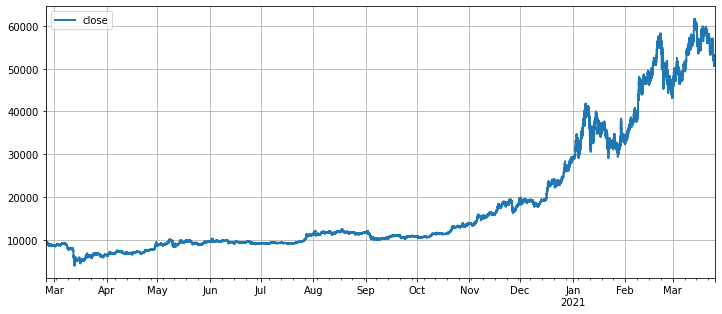

100%|██████████| 4/4 [00:00<00:00, 297.44it/s]

2021-04-06 19:42:30.279016 Test dataset stats: DatasetStatistics(integer_dataset=False, max_target=61700.0, mean_abs_target=13940.124977742398, mean_target=13940.124977742398, mean_target_length=95473.0, max_target_length=113780, min_target=3882.219970703125, feat_static_real=[], feat_static_cat=[{0}], num_past_feat_dynamic_real=0, num_feat_dynamic_real=0, num_feat_dynamic_cat=0, num_missing_values=0, num_time_observations=381892, num_time_series=4, scale_histogram=gluonts.dataset.stat.ScaleHistogram(base=2.0, bin_counts={14: 1, 13: 3}, empty_target_count=0))


In [9]:
#
# Define test data and make a prediction
#

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.stat import calculate_dataset_statistics

test_dataset_filename = dataset_dir_path / config.TEST_DATASET_FILENAME
df = pd.read_csv(filepath_or_buffer=test_dataset_filename, header=0, index_col=0)
a_time = "2020-11-20 12:50:00"
b_time = "2021-01-20 15:55:00"
c_time = "2021-01-20 17:10:00"

test_dataset = ListDataset(
    [
        # # This is first so we can easily graph the entire test dataset below
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df["close"][:],

            FieldName.ITEM_ID: "close",
            FieldName.FEAT_STATIC_CAT: pd.np.array([0]),

            # FieldName.FEAT_DYNAMIC_REAL: [
            #     df['open'][:],
            #     df['high'][:],
            #     df['low'][:],
            #     df['volume'][:]
            # ],
            # FieldName.ITEM_ID: "BTC/USDT",
        },
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df["close"][:a_time],

            FieldName.ITEM_ID: "close",
            FieldName.FEAT_STATIC_CAT: pd.np.array([0]),

            # FieldName.FEAT_DYNAMIC_REAL: [
            #     df['open'][:a_time],
            #     df['high'][:a_time],
            #     df['low'][:a_time],
            #     df['volume'][:a_time]
            # ],
            # FieldName.ITEM_ID: "BTC/USDT",
        },
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df["close"][:b_time],

            FieldName.ITEM_ID: "close",
            FieldName.FEAT_STATIC_CAT: pd.np.array([0]),

            # FieldName.FEAT_DYNAMIC_REAL: [
            #     df['open'][:b_time],
            #     df['high'][:b_time],
            #     df['low'][:b_time],
            #     df['volume'][:b_time]
            # ],
            # FieldName.ITEM_ID: "BTC/USDT",
        },
        {
            FieldName.START: df.index[0],
            FieldName.TARGET: df["close"][:c_time],

            FieldName.ITEM_ID: "close",
            FieldName.FEAT_STATIC_CAT: pd.np.array([0]),

            # FieldName.FEAT_DYNAMIC_REAL: [
            #     df['open'][:c_time],
            #     df['high'][:c_time],
            #     df['low'][:c_time],
            #     df['volume'][:c_time]
            # ],
            # FieldName.ITEM_ID: "BTC/USDT",
        }
    ],
    freq=config.DATASET_FREQ
)

to_pandas(next(iter(test_dataset)))[:].plot(figsize=(12, 5), linewidth=2)
plt.grid()
plt.legend(["close"])
plt.show()

test_statistics = calculate_dataset_statistics(test_dataset)
LOGGER.log(f"Test dataset stats: {test_statistics}")

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

Running evaluation: 100%|██████████| 4/4 [00:00<00:00, 32.13it/s]


2021-04-06 19:42:38.535281 {
    "MSE": 4842283.958333334,
    "abs_error": 115894.443359375,
    "abs_target_sum": 1673847.96875,
    "abs_target_mean": 34871.832682291664,
    "seasonal_error": 22.135253504060895,
    "MASE": 129.2403049247348,
    "MAPE": 0.08073241698245208,
    "sMAPE": 0.08158669372399649,
    "OWA": NaN,
    "MSIS": 2634.176429667353,
    "QuantileLoss[0.1]": 155908.482421875,
    "Coverage[0.1]": 0.020833333333333332,
    "QuantileLoss[0.5]": 115894.44140625,
    "Coverage[0.5]": 0.2708333333333333,
    "QuantileLoss[0.9]": 123798.09765624997,
    "Coverage[0.9]": 0.7291666666666667,
    "RMSE": 2200.5190202162157,
    "NRMSE": 0.06310305054123713,
    "ND": 0.0692383331838213,
    "wQuantileLoss[0.1]": 0.09314375339494226,
    "wQuantileLoss[0.5]": 0.06923833201697399,
    "wQuantileLoss[0.9]": 0.07396018035538807,
    "mean_absolute_QuantileLoss": 131867.00716145834,
    "mean_wQuantileLoss": 0.0787807552557681,
    "MAE_Coverage": 0.1597222222222222
}


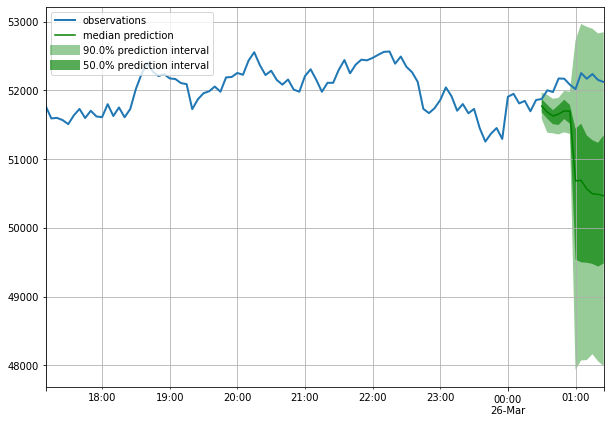

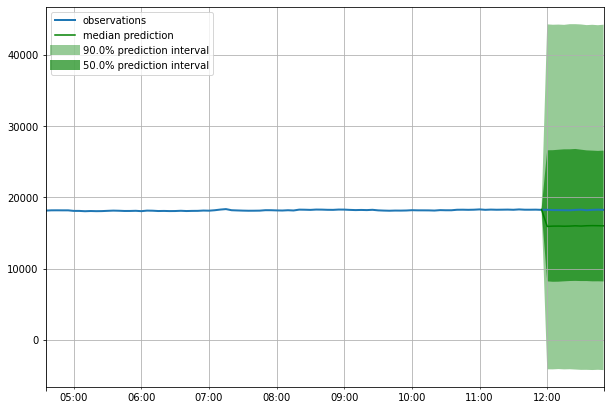

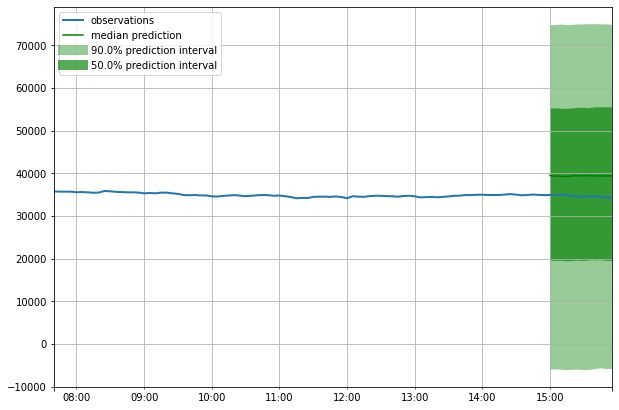

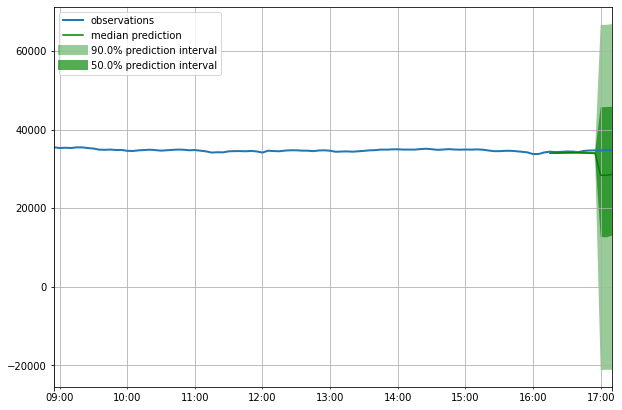

In [10]:
#
# Evaluate and visualize the prediction
#
import json

from gluonts.evaluation import Evaluator, MultivariateEvaluator

forecasts = list(forecast_it)
forecast_entry = forecasts[0]
tss = list(ts_it)

# LOGGER.log(f"Number of sample paths: {forecast_entry.num_samples}")
# LOGGER.log(f"Dimension of samples: {forecast_entry.samples.shape}")
# LOGGER.log(f"Start date of the forecast window: {forecast_entry.start_date}")
# LOGGER.log(f"Frequency of the time series: {forecast_entry.freq}")

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_dataset))

LOGGER.log(json.dumps(agg_metrics, indent=4))
item_metrics.head()

plot_prob_forecasts(tss, forecasts)

In [11]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(UTILS, LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{config.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{config.TEST_DATASET_FILENAME}"

# Note: Feel free to tune the tuner, i.e. update max number of jobs and hyperparameters. Default is 10 jobs, but you
# may want to change this as you refine the model. Additionally, if you find the best model has a parameter at the
# end of the range you gave it, then you should look to move that range to determine if the model performs better
# along that vector
tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, dataset_dir_uri)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateHyperParameterTuningJob operation: The account-level service limit 'ml.g4dn.xlarge for spot training job usage' is 2 Instances, with current utilization of 0 Instances and a request delta of 3 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
